### Neurophysiology and Biophysics - Practical course WS 2024/25
__Cornelia Kopp-Scheinpflug & Kay Thurley__

# Miniproject: Gap junctions and network synchorization

In this notebook we simulate a small network of electrically coupled Drosophila motoneurons. The network shows different regimes of synchrony depending on the coupling strength of the GAP junctions, which is supposed to underly the insect's flight. The model was used in Hürkey et al. (2023) and adapted by Kay Thurley (2024).


_Requirements:_ You will need Python 3 and the packages Numpy, Matplotlib and BRIAN2.


We start by importing the relevant packages.

In [47]:
import numpy as np
from brian2 import *
import sys, os
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())
import json

from utils.brianutils import units
from utils.random_initial_conditions import *
from utils.sim import *
from utils.convert_ggap_ccs import *
from utils.spiketime_analysis_helper import *

Then we define load some parameters and define the neuron.

In [48]:
md_SNL = json.load(open("cfg/Berger_SNL.json"))
md_SNIC = json.load(open("cfg/Berger_SNIC.json"))
ggap_hom = np.load('cfg/ggap_hom.npy')*nS
ggap_het = np.load('cfg/ggap_het.npy')*nS

In [49]:
# noise free simulations
# ## case1: weak SNL
# used for figure 3B
N = 5
g_gap = ggap_het
# g_gap = .15*nS
dur = 10*second
solver = 'rk4'#'rk4'
dt = 100*us
# noise 5e-8 is too high 
# noise 1e-8 it low enough to get 2 states
# noise 2e-8 gives 10 states!

# try noise levels between 
noise_stdev = None
fname='SNL_weakcoupling_nonoise'

φs_chosen = np.array([0.9, 0.6, 0.5, 0.7, 0.8])
# φs_chosen = np.array([0.5, 0.6, 0.9, 0.7, 0.8])
initial_values = pick_initial_phase_SNL(φs_chosen)
StM1, SpM1 = run_sim(N, md_SNL, g_gap, None, initial_values=initial_values,
                     dur=dur, σnoise=noise_stdev, solver=solver, dt=dt)

Starting simulation at t=0. s for a duration of 10. s
7.2834 s (72%) simulated in 10s, estimated 4s remaining.
10. s (100%) simulated in 13s


Text(0.97, 0.184, '[mV]')

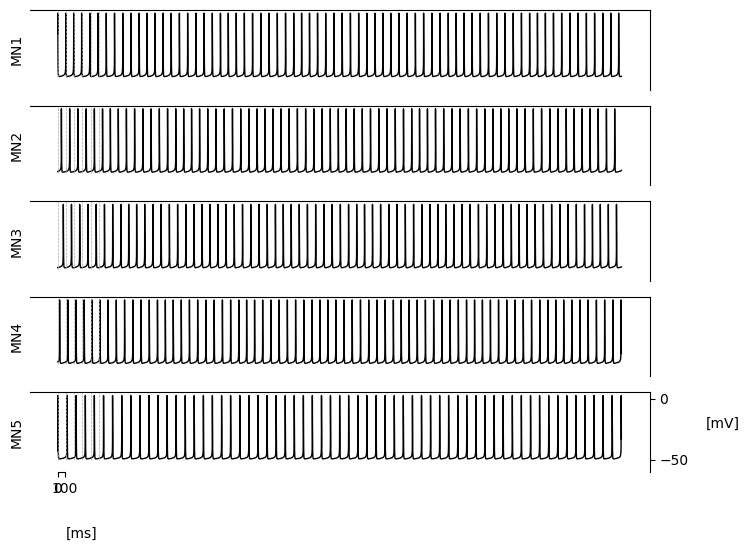

In [50]:
fig, ax = plt.subplots(5, 1, figsize=(8, 6))

ts=StM1.t_
per=np.median(np.diff(SpM1.t_[SpM1.i==0]))*second
t_unit=ms
N=5

tstart = SpM1.t_[SpM1.i==0][SpM1.t_[SpM1.i==0]>2].min()
m=(ts>tstart) & (ts<tstart+10)
for i in range(N):
    ax[i].plot(StM1.t[m]/ms-tstart*1000, StM1.v[i][m]/mV, c='k',lw=1)
    ax[i].spines['left'].set_visible(False)
    ax[i].set_ylabel('MN{}'.format(i+1))
    ax[i].set_yticks([])
    ax[i].set_ylim(-60,)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].set_xticks([])
    # shift = 2000
    # ax[i].set_xlim(0 + shift,300 + shift)

    for k in range(0,6):
        ax[i].plot([k*per/t_unit,k*per/t_unit],[-50,10],'--',lw=0.5,c='darkgrey')


ax[-1].set_xticks([0,100])
ax[-1].spines['bottom'].set_bounds(0,100)
ax[-1].spines['bottom'].set_visible(True)
fig.text(0.17,0.0,'[ms]')

ax[-1].spines['right'].set_visible(True)
ax[-1].yaxis.tick_right()
ax[-1].set_yticks([-50,0])
fig.text(0.97,0.184,'[mV]')

0.06359999999999999 9.905299999999999
98417


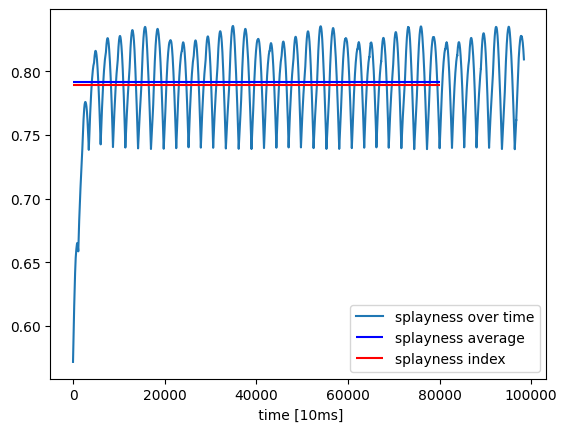

In [51]:
from utils.spiketime_analysis_helper import *
# Splayness index
# Make sure tstart tend and dt have same units 
tmin, tmax = get_tminmax(SpM1)
print(tmin, tmax)
print(len(get_splayness(SpM1, tmin, tmax, 100e-6)[0]))
plt.plot(get_splayness(SpM1, tmin, tmax, 100e-6)[0], label ='splayness over time')
plt.hlines(np.mean(get_splayness(SpM1, tmin, tmax, 100e-6)[0]),0, 80000, color='b', label = 'splayness average')
plt.hlines(get_splayness(SpM1, tmin, tmax, 100e-6)[1],0, 80000, color='r', label = 'splayness index')
plt.xlabel(' time [10ms]')
plt.legend()
plt.show()

In [52]:
len(StM1.v[0])

100000

In [53]:
from collections import defaultdict

def extract_splay_sequences_ignored(spike_ids, spike_times, N=5, ignore_id=4):
    """
    Extract repeating splay sequences, ignoring spikes from a given neuron ID.

    Parameters
    ----------
    spike_ids : array-like
        Neuron IDs for each spike event (e.g., SpM.i)
    spike_times : array-like
        Corresponding spike times (e.g., SpM.t)
    N : int
        Total neuron count (used for pattern length)
    ignore_id : int
        Neuron ID to ignore (e.g., 4)

    Returns
    -------
    pattern_times : dict
        {pattern_string: [list of start times]}
    """

    # Filter out ignored neuron spikes
    valid_mask = spike_ids != ignore_id
    spike_ids = spike_ids[valid_mask]
    spike_times = spike_times[valid_mask]

    pattern_times = defaultdict(list)

    # find indices where neuron 0 spikes
    zero_spike_indices = np.where(spike_ids == 0)[0]

    # each pattern is now N-1 neurons long
    pattern_len = N - 1

    for idx in zero_spike_indices:
        if idx + pattern_len <= len(spike_ids):
            pattern = ''.join(str(x+1) for x in spike_ids[idx:idx + pattern_len])
            t = spike_times[idx]  # start time
            pattern_times[pattern].append(t)

    return pattern_times

def extract_splay_sequences(spike_ids, spike_times, N=5):
    pattern_times = defaultdict(list)

    # find indices where neuron 0 spikes
    zero_spike_indices = np.where(spike_ids == 0)[0]

    for idx in zero_spike_indices:
        # make sure there are at least N spikes after this 0
        if idx + N <= len(spike_ids):
            pattern = ''.join(str(x+1) for x in spike_ids[idx:idx + N])
            t = spike_times[idx]  # time of this pattern’s start (neuron 0 spike)
            pattern_times[pattern].append(t)

    return pattern_times

defaultdict(<class 'list'>, {'1423': [15.3 * msecond, 118.6 * msecond, 228.3 * msecond, 0.342 * second, 0.4575 * second, 0.5742 * second, 0.6904 * second, 0.8067 * second, 0.9224 * second, 1.0375 * second, 1.1478 * second, 1.2595 * second, 1.3732 * second, 1.4882 * second, 1.6042 * second, 1.7202 * second, 1.8361 * second, 1.9519 * second, 2.0672 * second, 2.1806 * second, 2.2911 * second, 2.4034 * second, 2.5177 * second, 2.6332 * second, 2.7498 * second, 2.8659 * second, 2.9821 * second, 3.0977 * second, 3.2129 * second, 3.3233 * second, 3.4348 * second, 3.5482 * second, 3.6631 * second, 3.7789 * second, 3.895 * second, 4.0109 * second, 4.1269 * second, 4.2423 * second, 4.3567 * second, 4.467 * second, 4.579 * second, 4.6931 * second, 4.8085 * second, 4.925 * second, 5.0411 * second, 5.1572 * second, 5.2728 * second, 5.388 * second, 5.4987 * second, 5.6101 * second, 5.7232 * second, 5.8379 * second, 5.9536 * second, 6.07 * second, 6.1859 * second, 6.3021 * second, 6.4176 * second, 6.

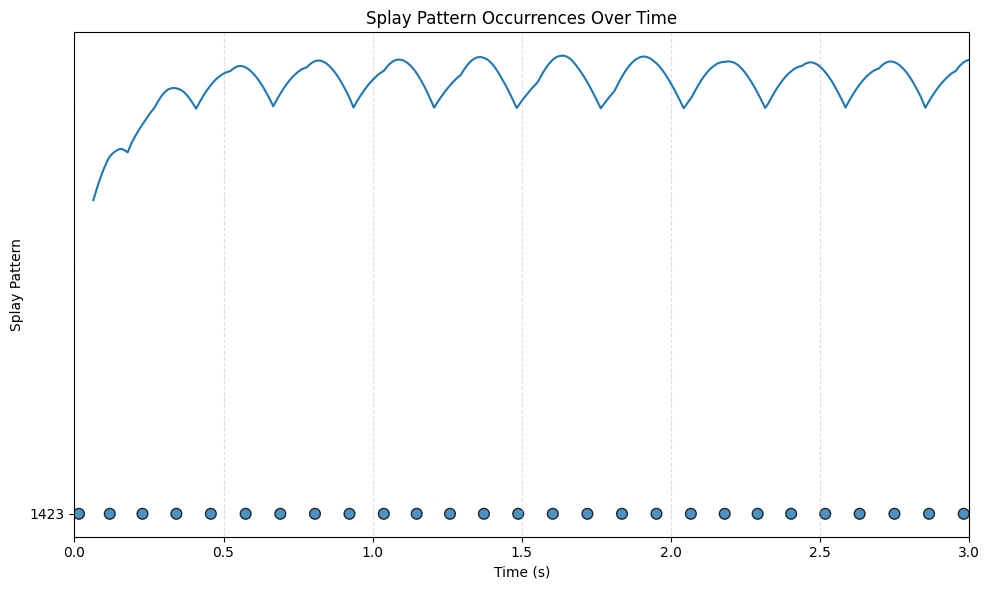

In [54]:
# patterns_times is your dict from extract_splay_sequences
patterns_times = extract_splay_sequences_ignored(SpM1.i, SpM1.t, N=5)
print(patterns_times)
# Get unique patterns and assign each a y-value
all_patterns = sorted(patterns_times.keys())
pattern_to_y = {p: i for i, p in enumerate(all_patterns)}

x = []  # time
y = []  # pattern index
colors = []  # color per pattern

cmap = plt.get_cmap('tab20')  # 20 distinct colors

for i, pattern in enumerate(all_patterns):
    times = patterns_times[pattern]
    x.extend(times)
    y.extend([pattern_to_y[pattern]]*len(times))
    colors.extend([cmap(i % 20)]*len(times))

plt.figure(figsize=(10,6))
plt.scatter(x, y, c=colors, s=60, edgecolor='k', alpha=0.8)
times = np.linspace(tmin, tmax, len(get_splayness(SpM1, tmin, tmax, 100e-6)[0]))
plt.plot(times, get_splayness(SpM1, tmin, tmax, 100e-6)[0], label ='splayness over time')
plt.yticks(range(len(all_patterns)), all_patterns)
plt.xlabel("Time (s)")
plt.ylabel("Splay Pattern")
plt.xlim(0, 3)
plt.title("Splay Pattern Occurrences Over Time")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

defaultdict(<class 'list'>, {'15423': [15.3 * msecond, 118.6 * msecond, 1.0375 * second, 1.1478 * second, 2.0672 * second, 2.1806 * second, 3.2129 * second, 3.3233 * second, 4.2423 * second, 4.3567 * second, 4.467 * second, 5.388 * second, 5.4987 * second, 6.5325 * second, 6.6427 * second, 7.563 * second, 7.6744 * second, 8.708 * second, 8.8182 * second, 9.7379 * second, 9.8506 * second], '14523': [228.3 * msecond, 0.342 * second, 1.2595 * second, 1.3732 * second, 2.2911 * second, 2.4034 * second, 2.5177 * second, 3.4348 * second, 3.5482 * second, 4.579 * second, 4.6931 * second, 5.6101 * second, 5.7232 * second, 6.7546 * second, 6.8685 * second, 7.7855 * second, 7.8983 * second, 8.93 * second, 9.0437 * second], '14253': [0.4575 * second, 0.5742 * second, 1.4882 * second, 1.6042 * second, 2.6332 * second, 2.7498 * second, 3.6631 * second, 3.7789 * second, 4.8085 * second, 4.925 * second, 5.8379 * second, 5.9536 * second, 6.9837 * second, 7.1001 * second, 8.0129 * second, 8.1285 * secon

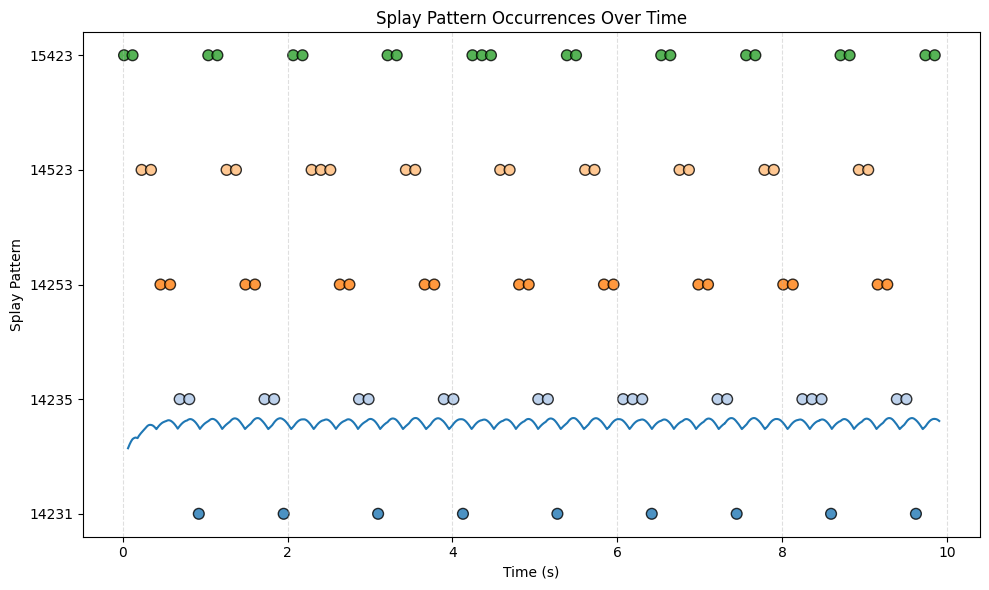

In [55]:
# patterns_times is your dict from extract_splay_sequences
patterns_times = extract_splay_sequences(SpM1.i, SpM1.t, N=5)
print(patterns_times)
# Get unique patterns and assign each a y-value
all_patterns = sorted(patterns_times.keys())
pattern_to_y = {p: i for i, p in enumerate(all_patterns)}

x = []  # time
y = []  # pattern index
colors = []  # color per pattern

cmap = plt.get_cmap('tab20')  # 20 distinct colors

for i, pattern in enumerate(all_patterns):
    times = patterns_times[pattern]
    x.extend(times)
    y.extend([pattern_to_y[pattern]]*len(times))
    colors.extend([cmap(i % 20)]*len(times))

plt.figure(figsize=(10,6))
plt.scatter(x, y, c=colors, s=60, edgecolor='k', alpha=0.8)
times = np.linspace(tmin, tmax, len(get_splayness(SpM1, tmin, tmax, 100e-6)[0]))
plt.plot(times, get_splayness(SpM1, tmin, tmax, 100e-6)[0], label ='splayness over time')
plt.yticks(range(len(all_patterns)), all_patterns)
plt.xlabel("Time (s)")
plt.ylabel("Splay Pattern")
# plt.xlim(0, 3)
plt.title("Splay Pattern Occurrences Over Time")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [56]:
patterns = extract_splay_sequences(SpM1.i, SpM1.t, N=5)
# Get unique patterns and assign each a y-value
all_patterns = sorted(patterns_times.keys())
pattern_to_y = {p: i for i, p in enumerate(all_patterns)}

# for p, times in patterns.items():
#     print(f"Pattern {p} occurred {len(times)} times at times {np.round(times,3)}")


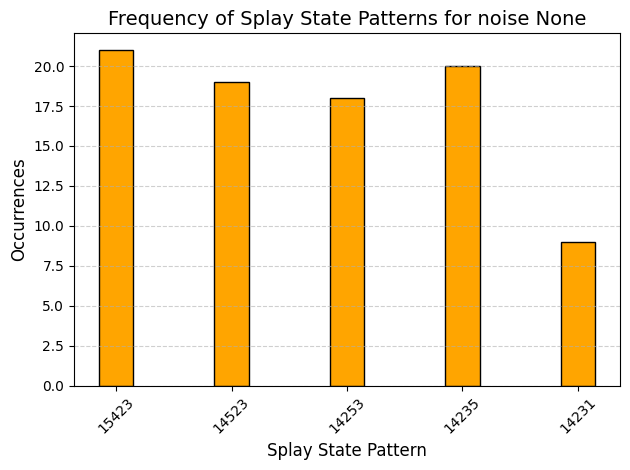

In [57]:
# Assuming you've already run:
# patterns = extract_splay_sequences(SpM1.i, SpM1.t, N=5)

# Extract data for plotting
pattern_names = list(patterns.keys())
occurrences = [len(times) for times in patterns.values()]

# # Sort by most frequent pattern (optional, for clarity)
# sorted_idx = np.argsort(occurrences)[::-1]
# pattern_names = [pattern_names[i] for i in sorted_idx]
# occurrences = [occurrences[i] for i in sorted_idx]

# Plot
plt.figure()
plt.bar(pattern_names, occurrences, color='orange', edgecolor='black', width=0.3)
plt.xlabel('Splay State Pattern', fontsize=12)
plt.ylabel('Occurrences', fontsize=12)
plt.title(f'Frequency of Splay State Patterns for noise {noise_stdev}', fontsize=14)
plt.xticks(rotation=45, ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
